In [1]:
################################################### IMPORT #########################################################
# importing of all needed libraries and modules.  
import wrangle as w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score 
from math import sqrt
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


In [2]:
train, validate, test=w.wrangle_zillow()

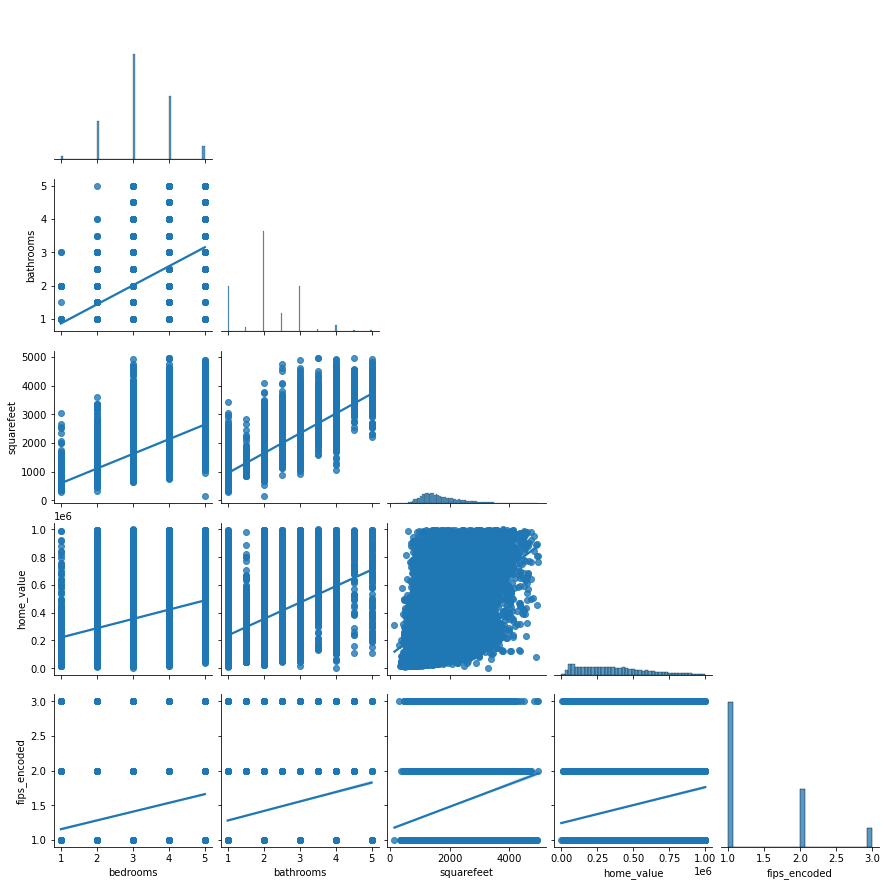

In [7]:
sns.pairplot(data=train, kind="reg", corner=True)

EXPLORATION: Use python libraries: pandas, statsmodels, scipy, numpy, matplotlib, seaborn, scikit-learn.
Perform statistical testing to understand correlations, significant differences in variables, variable interdependencies, etc.
Create visualizations that demonstrate relationships across and within attributes and target.
Use domain knowledge and/or information gained through exploration to construct new features.
Remove features that are noisy, provide no valuable or new information, or are redundant.
Use scikit-learn's preprocessing algorithms (feature selection, feature engineering, dummy variables, binning, clustering, e.g.) to turn attributes into features.

The .corr() method allowed me to not only see what correlates with the target variable, but how they correlate with each other.  It appears that bedrooms and bathrooms are a correlating factor.  Both have have a higher correlation with square feet, bedrooms at .65, but bathrooms is much higher at .81.

In [8]:
spearman_train_corr= train.corr(method='spearman')
spearman_train_corr

,bedrooms,bathrooms,squarefeet,home_value,fips_encoded
bedrooms,1.000000,0.606813,0.647345,0.233324,0.174709
bathrooms,0.606813,1.000000,0.808784,0.386688,0.206657
squarefeet,0.647345,0.808784,1.000000,0.419885,0.202285
home_value,0.233324,0.386688,0.419885,1.000000,0.209850
fips_encoded,0.174709,0.206657,0.202285,0.209850,1.000000


In [9]:
# Use a scipy stats function spearmanr to calculate the correlation coefficient and the p-value.
def spearman_test(df, target_var, test_var):
    r, p_value = spearmanr(train[target_var], df[test_var])
    print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

In [10]:
spearman_test(train, 'home_value', 'bedrooms')

Correlation Coefficient: 0.23332401774221348
P-value: 0.0


In [11]:
spearman_test(train, 'home_value', 'bathrooms')

Correlation Coefficient: 0.38668793751190295
P-value: 0.0


In [12]:
spearman_test(train, 'home_value', 'squarefeet')

Correlation Coefficient: 0.41988521240646987
P-value: 0.0


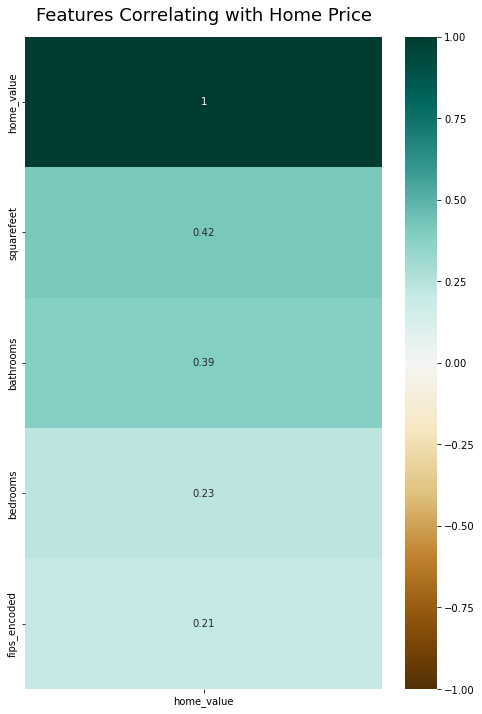

In [13]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['home_value']].sort_values(by='home_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

The variables 'bedrooms', 'bathrooms', 'squarefeet' have p values of 0 which shows a significant correlation between them and the target variable, home value.

Based on my correlation coefficient and my p-value, I reject my Null hypothesis that there is no correlation between independent variables of bedrooms, bathrooms, and square feet and target variable of home value.

Although all of the independent variables have positive correlations with the target variable, squarefeet is more correlated. This looks to be the best predictor of our target variable. I will  perform a simple linear regression first. If I want to go back and do some feature engineering with my other independent variables, I could do that and see if I can improve on my accuracy. And since bathrooms is highly correlated with square feet, I might use that.

SCALING

In [14]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['bedrooms', 'bathrooms', 'squarefeet'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = MinMaxScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [15]:
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=True)

In [16]:
train_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25986 entries, 6115 to 581
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      25986 non-null  float64
 1   bathrooms     25986 non-null  float64
 2   squarefeet    25986 non-null  float64
 3   home_value    25986 non-null  float64
 4   fips_encoded  25986 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 2.2 MB


In [17]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(16,9))
    df_scaled = df.copy()
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()
#return fig, axs

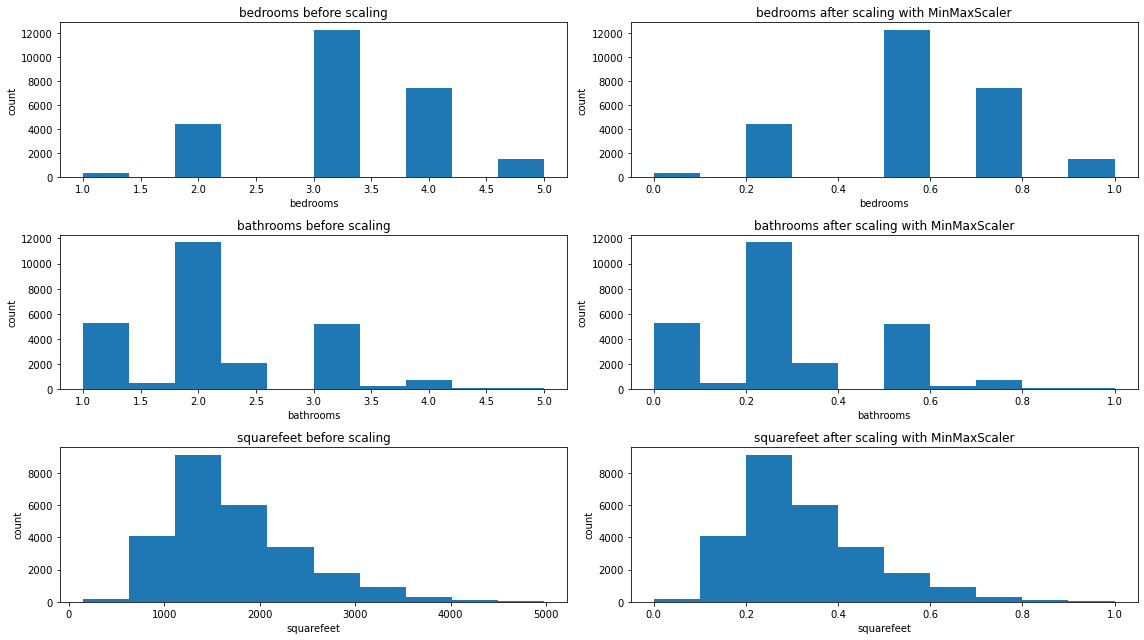

In [18]:
# MinMaxScaler Applied
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=['bedrooms', 'bathrooms', 'squarefeet'], 
                 bins=10)

MODELING

In [19]:
X_train_scaled=train_scaled.drop(columns=['home_value'])
y_train=train_scaled.home_value

In [20]:
X_validate_scaled=validate_scaled.drop(columns=['home_value'])
y_validate=validate_scaled.home_value

In [21]:
X_test_scaled=test_scaled.drop(columns=['home_value'])
y_test=test_scaled.home_value

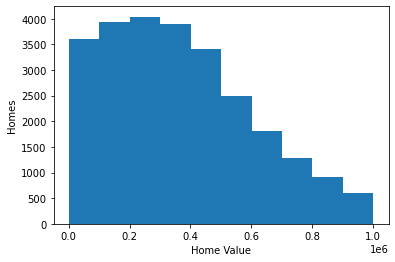

In [22]:
plt.hist(y_train)
plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.show()


BASELINE

In [23]:

# We need y_train and y_validate (and test) to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. Predict home_value_pred_mean
home_value_pred_mean = y_train['home_value'].mean()
y_train['home_value_pred_mean'] = home_value_pred_mean
y_validate['home_value_pred_mean'] = home_value_pred_mean

# 2. compute home_value_pred_median
home_value_pred_median = y_train['home_value'].median()
y_train['home_value_pred_median'] = home_value_pred_median
y_validate['home_value_pred_median'] = home_value_pred_median

# 3. RMSE of home_value_pred_mean
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of home_value_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  235141.65 
Validate/Out-of-Sample:  234344.53
RMSE using Median
Train/In-Sample:  237312.35 
Validate/Out-of-Sample:  236131.18


OLS

In [24]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm)**(1/2)

# predict validate
y_validate['home_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm)**(1/2)

print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS
Training/In-Sample:  206103.53427370606 
Validation/Out-of-Sample:  205052.05700159754


POLYNOMIAL REGRESSION degree 2

In [25]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [26]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['home_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm2)**(1/2)

# predict validate
y_validate['home_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm2)**(1/2)

print("RMSE for Poly 2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Poly 2
Training/In-Sample:  204817.78133544177 
Validation/Out-of-Sample:  203734.47951521567


LASSOLARS

In [27]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lars)**(1/2)

# predict validate
y_validate['home_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  206103.9762725642 
Validation/Out-of-Sample:  205056.07910831872


In [28]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['home_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_glm)**(1/2)

# predict validate
y_validate['home_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_glm)**(1/2)

print("RMSE for Tweedie\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Tweedie
Training/In-Sample:  230490.8872543744 
Validation/Out-of-Sample:  229745.21998190065


POLYNOMIAL REGRESSION degree 3

In [29]:
from sklearn.preprocessing import PolynomialFeatures
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [30]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['home_value_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.home_value_pred_lm3)**(1/2)

# predict validate
y_validate['home_value_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.home_value_pred_lm3)**(1/2)

# predict on test
y_test['home_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.home_value, y_test.home_value_pred_lm3)**(1/2)

print("RMSE for Poly 3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\nTesting/Out-of-Sample Performance: ", rmse_test)

RMSE for Poly 3
Training/In-Sample:  204428.94260853203 
Validation/Out-of-Sample:  203237.347981703 
Testing/Out-of-Sample Performance:  202729.41849139714


EVALUATE

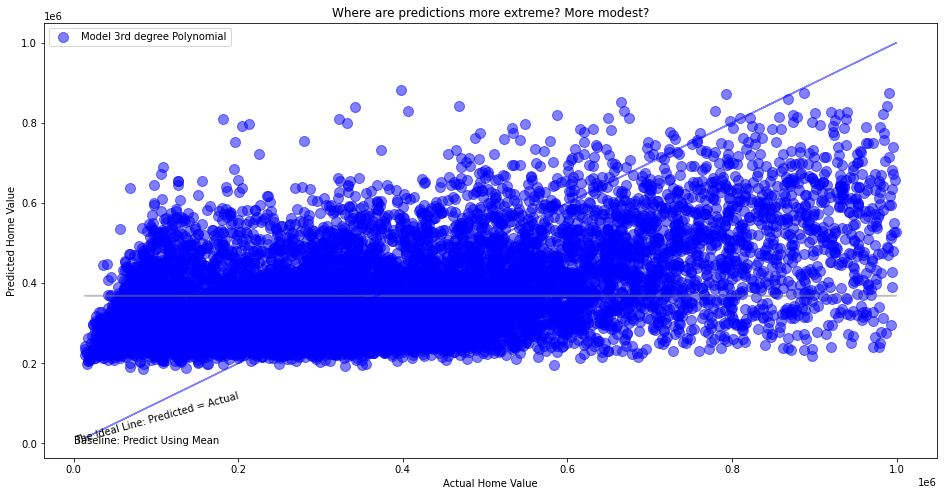

In [31]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.home_value, y_validate.home_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.home_value, y_validate.home_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.home_value, y_validate.home_value_pred_lm3, 
            alpha=.5, color="blue", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Where are predictions more extreme? More modest?")
plt.show()


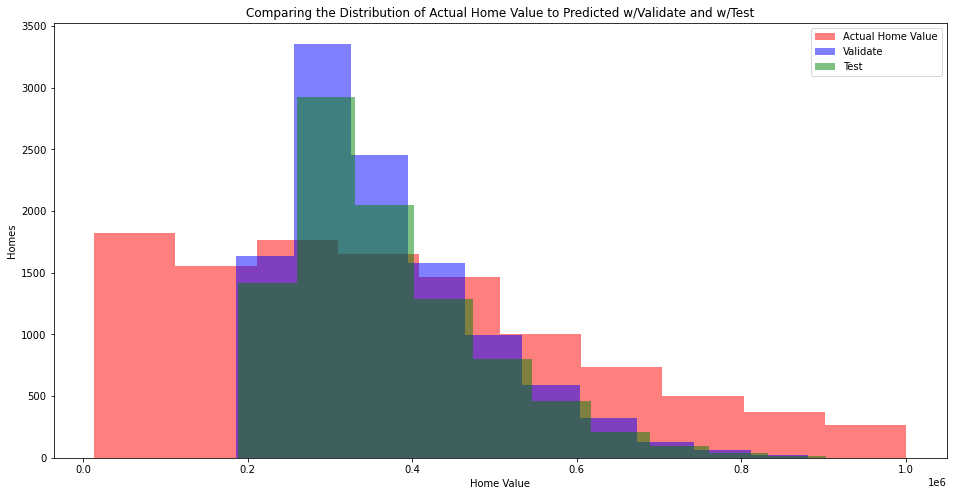

In [32]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.home_value, color='red', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.home_value_pred_lm3, color='blue', alpha=.5, label="Validate")
plt.hist(y_test.home_value_pred_lm3, color='green', alpha=.5, label='Test')
plt.xlabel("Home Value")
plt.ylabel("Homes")
plt.title("Comparing the Distribution of Actual Home Value to Predicted w/Validate and w/Test")
plt.legend()
plt.show()